In [1]:
import sys

sys.path.append(".")

from src.models.unet import UNet
from src.models.vae import *
from src.components.components import *

from src.modules.autoencoder import AutoEncoder
from src.modules.latent_diffusion_model import LatentDiffusionModel

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import pytorch_lightning as pl


/home/engineer/anaconda/envs/palamariuk-genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')

Device: cuda



# 2

(2 pt.) Using VAE from previous HW (re-train on MNIST if need) and diffusion implementation from above, implement and train latent diffusion model, compare inference from DDPM and DDIM

In [4]:
vae = VariationalAutoEncoder(in_channels=1).to(device)
autoencoder = AutoEncoder(vae, lr=1e-3).to(device)

/home/engineer/anaconda/envs/palamariuk-genai/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'vae' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae'])`.


In [7]:
vae

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=64, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=64, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReL

In [5]:
retrain = False

if retrain:
    trainer = pl.Trainer(max_epochs=50, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(autoencoder, train_loader)
    torch.save(autoencoder.vae, 'models/weights/vae_100.pth')
else:
    autoencoder.vae = torch.load('models/weights/vae_100.pth', weights_only=False).to(device)

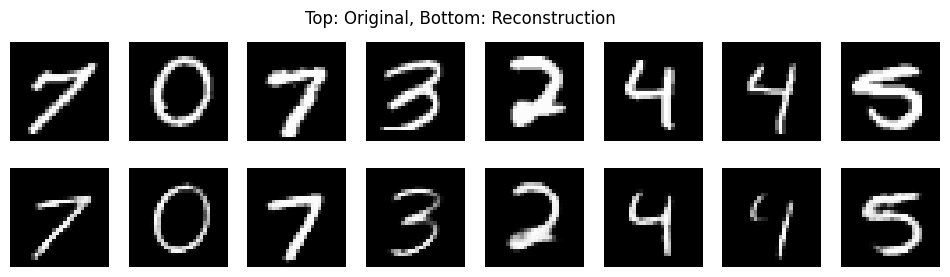

In [6]:
autoencoder.vae.eval()
with torch.no_grad():
    for images, _ in iter(train_loader):
        images = images.to(device)
        recon, _, _ = autoencoder.vae(images)
        break

# Plot original vs. reconstruction
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(images[i, 0].cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i, 0].cpu(), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle("Top: Original, Bottom: Reconstruction")
plt.show()

In [8]:
ldm_unet = UNet(
    in_channels=1,     # Input channels equal to the VAE's latent dimension.
    out_channels=1,    # Output channels equal to the latent dimension.
    base_channels=64,
    channel_mults=(1,2,4),  # You can adjust this tuple to change the network's depth.
    num_res_blocks=2,   # Number of ResBlocks at each down/up sampling stage.
    time_emb_dim=256,   # Dimension for time embedding.
).to(device)

latent_diffusion = LatentDiffusionModel(autoencoder=autoencoder, unet=ldm_unet, T=1000, beta_start=1e-4, beta_end=2e-2, lr=1e-4, latent_dim=64).to(device)

In [9]:
retrain = False

if retrain:
    trainer = pl.Trainer(max_epochs=50, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(latent_diffusion, train_loader)
    torch.save(latent_diffusion.unet, 'models/weights/ldm_unet.pth')
else:
    latent_diffusion.unet = torch.load('models/weights/ldm_unet.pth', weights_only=False).to(device)

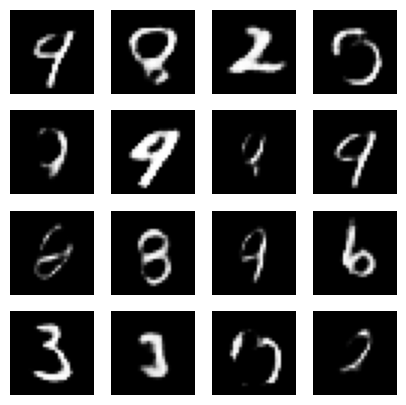

In [10]:
samples = latent_diffusion.sample_ddim(batch_size=16, ddim_steps=100)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()

Execution time of DDIM - 695 ms

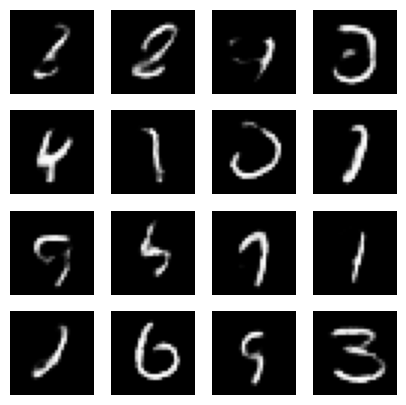

In [11]:
samples = latent_diffusion.sample_ddpm(batch_size=16)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()

 Execution time of DDPM - 5 s 677 ms